**Martí Gelabert Gómez 😎**
# Template Matching

It is a simple idea, is a **model base approach** that tries to search correlations in between the **image** and our **model** (template). Generally the performance depends on the area and we usually evaluate **a part of the image** and not the entire one. 

Some of the basic characteristics of this techniques are listed in the following points:

- Works well with translations but not for rotations.
- Template matching is translation invariant by definition.
- By definitions is good with **Gaussian noise**.
- Has a really high computational cost without some tweaks.
- When dealing with **rotations** or some kind of non-affine transformations we are better off applying key point detection, local invariant descriptors, and key point matching.

Each **template** represents the object or part of it. We expect it to appear with minimum variations, not taking in count the rotation and scale invariant.
One possible solution to cope with this problem could be the use of key features.This way the problem is to really get good key points and reconstruct the original image.

NOTE: In general I haven't seen any diference dealing with noise.


In [ ]:
!git clone https://github.com/bmalcover/image3D

Cloning into 'image3D'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 1), reused 14 (delta 1), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow


def noisy(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    row,col,ch= image.shape
    mean = 0
    var = 1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    noisy = noisy.astype(np.uint8)
    noisy = cv2.cvtColor(noisy, cv2.COLOR_HSV2BGR)

    return noisy

## Multiple Templates aproach

Sound like a simple idea, just use more templates. In this [paper](https://link.springer.com/content/pdf/10.1007/978-3-540-77129-6_13.pdf) it is shown how RSTBC-invariant template matching works. Mainly by generating multiple templates from the original one and applying some transformations to it. This way, applying rotations and scalations to the original template we obtain a more robust model.


In [ ]:
image = cv2.imread("/content/image3D/Pattern Matching/input/cards_mini.png", 0)
template_base = cv2.imread("/content/image3D/Pattern Matching/input/diamond.png", 0)

templates = []
(h, w) = template_base.shape[:2]
(cX, cY) = (w // 2, h // 2)



# This loop create rotation variants of the original image
for i in range(45, 250, 20): 
  M = cv2.getRotationMatrix2D((cX, cY), i, 1.0)
  #rotated = cv2.warpAffine(template_base, M, (w, h))
  rotated = cv2.warpAffine(template_base, M, (w, h),
                           borderMode=cv2.BORDER_TRANSPARENT
                           )
  templates.append(rotated)

# adding original one
templates.append(template_base)

# And this one create scaled ones for each one
for i in range(len(templates)):
  for scale_percent in range(110,160, 10):
    width = int(templates[i].shape[1] * scale_percent / 100)
    height = int(templates[i].shape[0] * scale_percent / 100)
    dim = (width, height)

    
    # resize image
    resized = cv2.resize(templates[i], dim, interpolation = cv2.INTER_AREA)
    templates.append(resized)




In [ ]:
# Just in case you need to see the template variations
#for im in templates:
#  cv2_imshow(im)

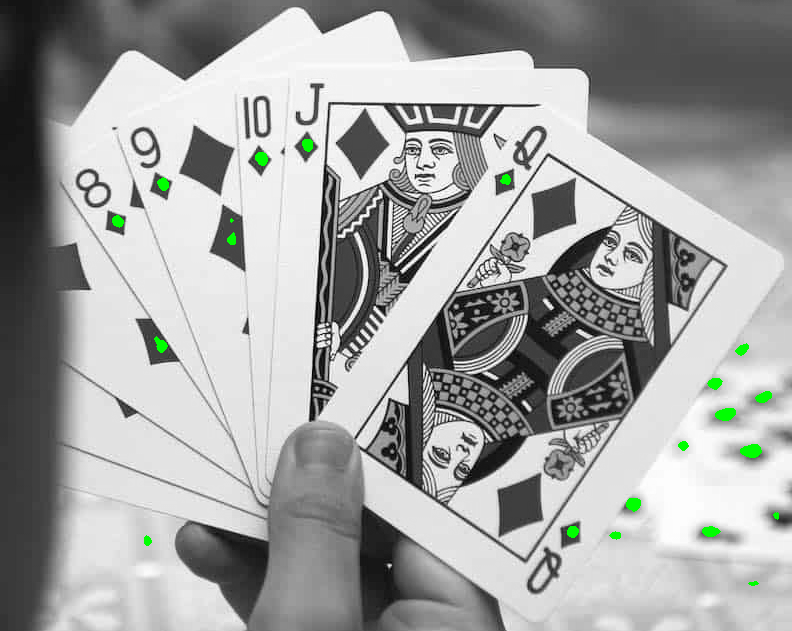

In [ ]:
centers = []

# the best one
#threshold = 0.75
threshold = 0.65

for template in templates:
  #result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)
  result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)

  # we retain all the pixel values above and equal to the threshold
  # but with a strange list structure, an array of y and x separated.
  # they correspond on the same index.
  detections = np.where(result>=threshold)

  # https://www.youtube.com/watch?v=ffRYijPR8pk&list=PL1m2M8LQlzfKtkKq2lK5xko4X-8EZzFPI&index=2
  detections = list(zip(*detections[::-1])) # zip retuns a new list from the unpacked x and y coord list
  
  #print(len(detections)," detections found! with threshold = ", threshold)
  w, h = template.shape
  
  for det in detections:
    center = (det[0]+int(w/2),det[1]+int(h/2))
    centers.append(center)
    # Getting the best match 
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    #min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    #cv2.circle(image_output, center, radius=1, color=(0, 255, 0), thickness=-1)


image_output = image.copy()
image_output = cv2.cvtColor( image_output, cv2.COLOR_GRAY2RGB )
for c in centers:
  cv2.circle(image_output, c, radius=1, color=(0, 255, 0), thickness=-1)

cv2_imshow(image_output)

We are getting some fake positives due to the value of the threshold. Overall the fake positive belongs to the background. It could be a good idea to preproces it. As it can be seen, the blured annotations on the background cards could be mistaken easily by the diamond shape.

### Noisy multiple templates

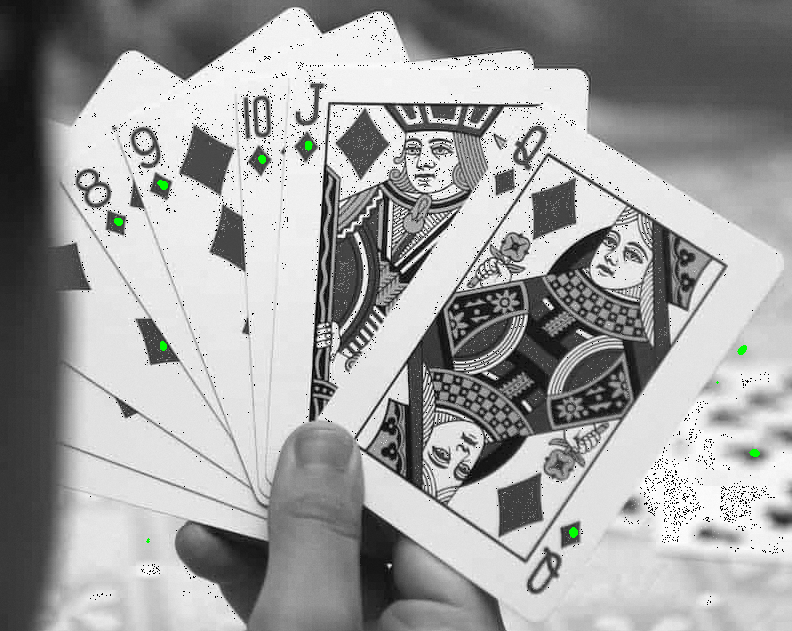

In [ ]:
image = cv2.imread("/content/image3D/Pattern Matching/input/cards_mini.png" )
image = noisy(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

template_base = cv2.imread("/content/image3D/Pattern Matching/input/diamond.png", 0)

templates = []
(h, w) = template_base.shape[:2]
(cX, cY) = (w // 2, h // 2)



# This loop create rotation variants of the original image
for i in range(45, 250, 20): 
  M = cv2.getRotationMatrix2D((cX, cY), i, 1.0)
  #rotated = cv2.warpAffine(template_base, M, (w, h))
  rotated = cv2.warpAffine(template_base, M, (w, h),
                           borderMode=cv2.BORDER_TRANSPARENT
                           )
  templates.append(rotated)

# adding original one
templates.append(template_base)

# And this one create scaled ones for each one
for i in range(len(templates)):
  for scale_percent in range(110,160, 10):
    width = int(templates[i].shape[1] * scale_percent / 100)
    height = int(templates[i].shape[0] * scale_percent / 100)
    dim = (width, height)

    
    # resize image
    resized = cv2.resize(templates[i], dim, interpolation = cv2.INTER_AREA)
    templates.append(resized)


centers = []

# the best one
#threshold = 0.75
threshold = 0.65

for t in templates:
  #result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)
  result = cv2.matchTemplate(image,t,cv2.TM_CCOEFF_NORMED)

  # we retain all the pixel values above and equal to the threshold
  # but with a strange list structure, an array of y and x separated.
  # they correspond on the same index.
  detections = np.where(result>=threshold)

  # https://www.youtube.com/watch?v=ffRYijPR8pk&list=PL1m2M8LQlzfKtkKq2lK5xko4X-8EZzFPI&index=2
  detections = list(zip(*detections[::-1])) # zip retuns a new list from the unpacked x and y coord list
  
  #print(len(detections)," detections found! with threshold = ", threshold)
  w, h = t.shape
  
  for det in detections:
    center = (det[0]+int(w/2),det[1]+int(h/2))
    centers.append(center)
    # Getting the best match 
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    #min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    #cv2.circle(image_output, center, radius=1, color=(0, 255, 0), thickness=-1)


image_output = image.copy()
image_output = cv2.cvtColor( image_output, cv2.COLOR_GRAY2RGB )
for c in centers:
  cv2.circle(image_output, c, radius=1, color=(0, 255, 0), thickness=-1)

cv2_imshow(image_output)

## Only one template for multiple detections (thresholding)

Improvements can be made to the matching method by using more than one template (eigenspaces)


(594, 759)
479  detections found! with threshold =  0.65


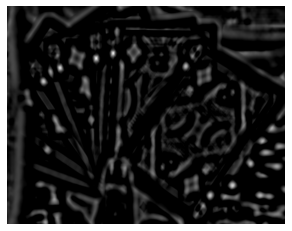

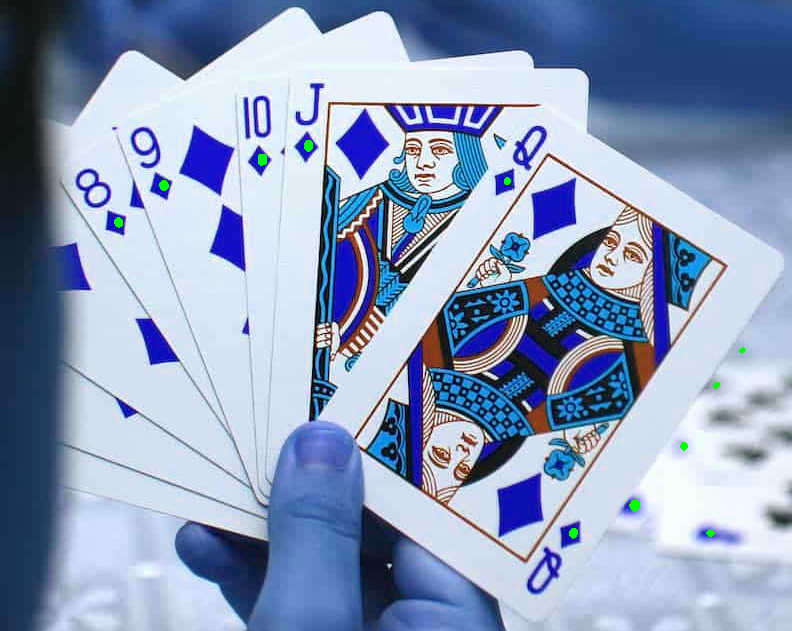

In [ ]:
image = cv2.imread("/content/image3D/Pattern Matching/input/cards_mini.png", cv2.IMREAD_UNCHANGED)
template = cv2.imread("/content/image3D/Pattern Matching/input/diamond.png", cv2.IMREAD_UNCHANGED)

#result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)
result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)


# the best one
#threshold = 0.75
threshold = 0.65 

print(result.shape)
# we retain all the pixel values above and equal to the threshold
# but with a strange list structure, an array of y and x separated.
# they correspond on the same index.
detections = np.where(result>=threshold)

# https://www.youtube.com/watch?v=ffRYijPR8pk&list=PL1m2M8LQlzfKtkKq2lK5xko4X-8EZzFPI&index=2
detections = list(zip(*detections[::-1])) # zip retuns a new list from the unpacked x and y coord list

print(len(detections)," detections found! with threshold = ", threshold)
w, h = template.shape[:-1]
image_output = image.copy()
for det in detections:
  center = (det[0]+int(w/2),det[1]+int(h/2))
  
  # Getting the best match 
  # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
  #min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
  cv2.circle(image_output, center, radius=1, color=(0, 255, 0), thickness=-1)


plt.imshow(cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.show()
cv2_imshow(cv2.cvtColor( image_output, cv2.COLOR_BGR2RGB ))


### Noisy Only One template

(594, 759)
185  detections found! with threshold =  0.65


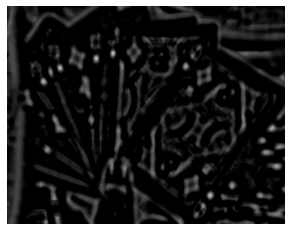

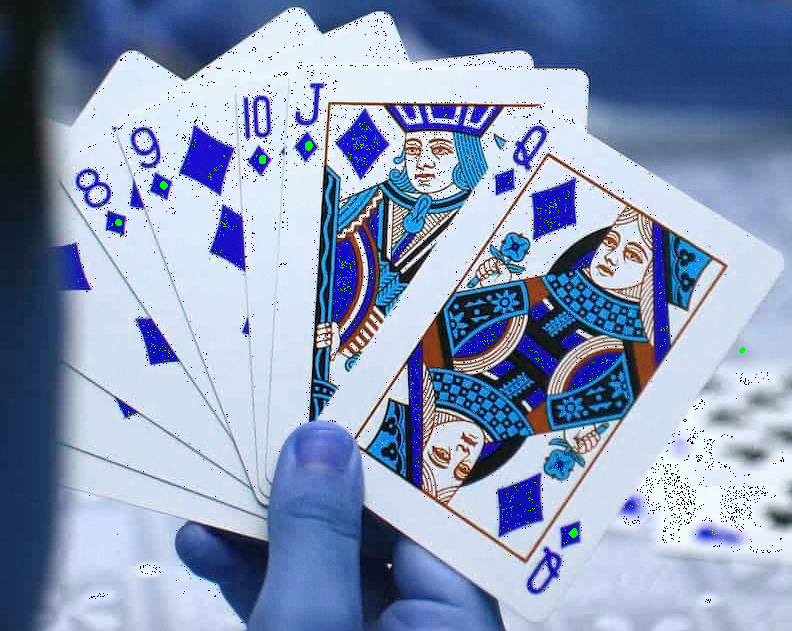

In [ ]:
image = cv2.imread("/content/image3D/Pattern Matching/input/cards_mini.png")
image = noisy(image)

template = cv2.imread("/content/image3D/Pattern Matching/input/diamond.png")

#result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)
result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)


# the best one
#threshold = 0.75
threshold = 0.65 

print(result.shape)
# we retain all the pixel values above and equal to the threshold
# but with a strange list structure, an array of y and x separated.
# they correspond on the same index.
detections = np.where(result>=threshold)

# https://www.youtube.com/watch?v=ffRYijPR8pk&list=PL1m2M8LQlzfKtkKq2lK5xko4X-8EZzFPI&index=2
detections = list(zip(*detections[::-1])) # zip retuns a new list from the unpacked x and y coord list

print(len(detections)," detections found! with threshold = ", threshold)
w, h = template.shape[:-1]
image_output = image.copy()
for det in detections:
  center = (det[0]+int(w/2),det[1]+int(h/2))
  
  # Getting the best match 
  # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
  #min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
  cv2.circle(image_output, center, radius=1, color=(0, 255, 0), thickness=-1)


plt.imshow(cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.show()
cv2_imshow(cv2.cvtColor( image_output, cv2.COLOR_BGR2RGB ))

## Trying every method

(594, 759)
213721  detections found! with threshold =  0.9


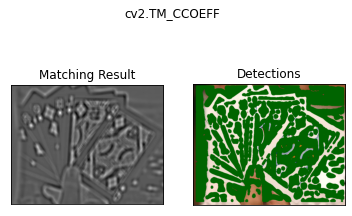

(594, 759)
17  detections found! with threshold =  0.9


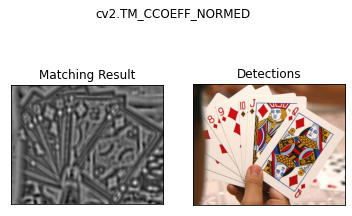

(594, 759)
450846  detections found! with threshold =  0.9


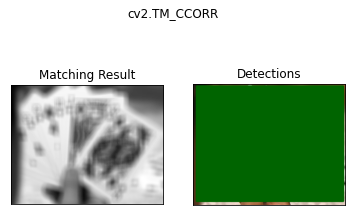

(594, 759)
289711  detections found! with threshold =  0.9


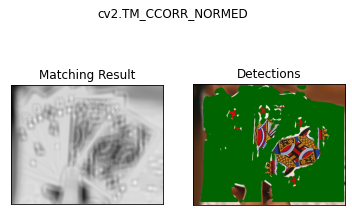

(594, 759)
450846  detections found! with threshold =  0.9


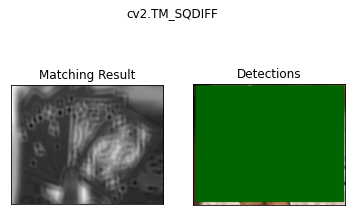

(594, 759)
772  detections found! with threshold =  0.9


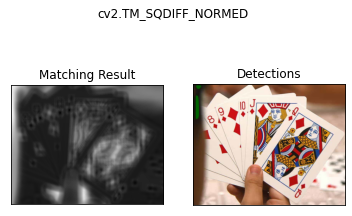

In [ ]:

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
  # Using color
  image = cv2.imread("/content/image3D/Pattern Matching/input/cards_mini.png", cv2.IMREAD_UNCHANGED)
  template = cv2.imread("/content/image3D/Pattern Matching/input/diamond.png", cv2.IMREAD_UNCHANGED)


  #result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)
  result = cv2.matchTemplate(image,template,eval(meth))
  #plt.imshow(cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
  #plt.axis('off')
  #plt.show()


  threshold = 0.9

  print(result.shape)
  # we retain all the pixel values above and equal to the threshold
  # but with a strange list structure, an array of y and x separated.
  # they correspond on the same index.
  detections = np.where(result>=threshold)
  

  # https://www.youtube.com/watch?v=ffRYijPR8pk&list=PL1m2M8LQlzfKtkKq2lK5xko4X-8EZzFPI&index=2
  detections = list(zip(*detections[::-1])) # zip retuns a new list from the unpacked x and y coord list



  print(len(detections)," detections found! with threshold = ", threshold)
  w, h = template.shape[:-1]
  image_output = image.copy()
  for det in detections:
    center = (det[0]+int(w/2),det[1]+int(h/2))
    
    # Getting the best match 
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    #min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    cv2.circle(image_output, center, radius=5, color=(0, 100, 0), thickness=-1)


  plt.subplot(121),plt.imshow(result,cmap = 'gray')
  plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(cv2.cvtColor(image_output, cv2.COLOR_BGR2RGB))
  plt.title('Detections'), plt.xticks([]), plt.yticks([])
  plt.suptitle(meth)
  plt.show()


## Feature Matching + Homography (Brutal Force)

This method should be powerfull enought to deal with translation and rotation invariance. Could be a good idea to select template features manually. Overall, seems like the algorithm finds diamond features well.


The problem we encounter here is that the template image is just too simple to get the correct orientation of the diamond. It's dificult to reconstruct the actual matches when the key points are to similar.

17


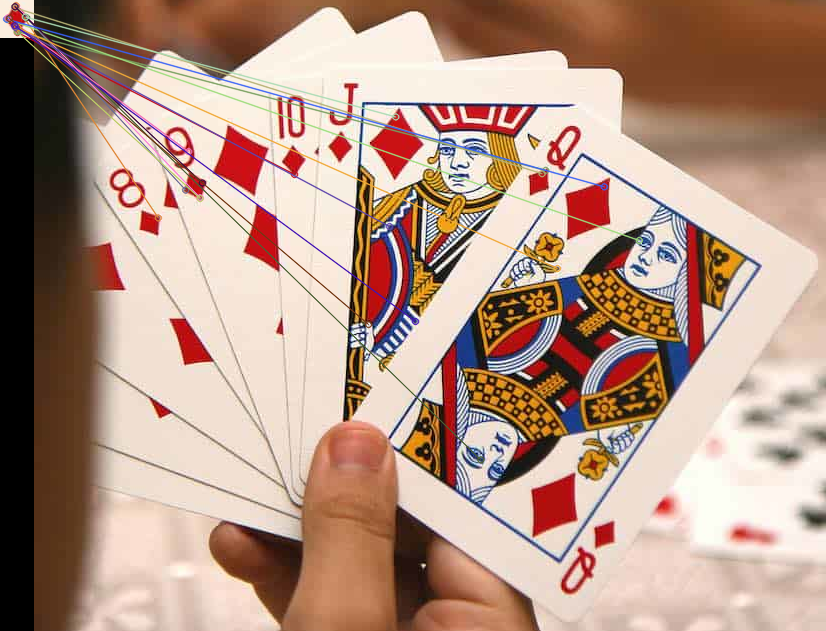

In [ ]:
# https://arxiv.org/pdf/1707.05647.pdf
# Basics of Brute-Force Matcher
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

template = cv2.imread("/content/image3D/Pattern Matching/input/diamond.png", 1)
image = cv2.imread("/content/image3D/Pattern Matching/input/cards_mini.png", 1)

orb = cv2.ORB_create(nfeatures=700,edgeThreshold=1)

kp1, des1 = orb.detectAndCompute(template, None)
kp2, des2 = orb.detectAndCompute(image, None)

# Find keypoints on descriptors
#brute = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
brute = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Best to less matchable
matches = brute.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
print(len(matches))
img_output = cv2.drawMatches(template,kp1,image,kp2, matches, None, flags=2)
cv2_imshow(img_output)